In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import KNNImputer


x_train = pd.read_csv('/content/X_train_NHkHMNU.csv')
y_train = pd.read_csv('/content/y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('/content/X_test_final.csv')

pd.set_option('display.max_columns', None)


In [2]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)


x_train_imputed


,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
0,1054.0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,-0.789557,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.0,1.0
1,2049.0,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0.0,1.0
2,1924.0,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0.0,1.0
3,297.0,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1.0,0.0
4,1101.0,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,-0.471847,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,-0.238427,0.876984,0.819520,1.320373,1.0,0.0
1490,1674.0,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,-1.071237,0.932633,-0.085690,0.356356,0.0,1.0
1491,748.0,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,1.0,0.0
1492,1454.0,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.619473,0.918251,0.378080,-0.973969,-0.828580,-0.137667,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,0.0,1.0


In [3]:
x_train_imputed['FR_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['FR_WINDPOW']))
x_train_imputed['DE_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['DE_WINDPOW']))

x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()

x_train_imputed['FR_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_RESIDUAL_LOAD'].cumsum()
x_train_imputed['DE_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_RESIDUAL_LOAD'].cumsum()

x_train_imputed['FR_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR']
x_train_imputed['FR_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

x_train_imputed['DE_NON_RENEWABLE'] = x_train_imputed['DE_COAL']+ x_train_imputed['DE_GAS'] + x_train_imputed['DE_NUCLEAR'] + x_train_imputed['DE_LIGNITE']
x_train_imputed['DE_RENEWABLE'] = x_train_imputed['DE_HYDRO']+ x_train_imputed['DE_SOLAR'] + x_train_imputed['DE_WINDPOW']

x_train_imputed['EXCESS_PROD'] = x_train_imputed['FR_NON_RENEWABLE']+x_train_imputed['FR_RENEWABLE'] - x_train_imputed['FR_CONSUMPTION']- x_train_imputed['FR_NET_EXPORT']
x_train_imputed['EXCESS_PROD'] =  x_train_imputed['DE_NON_RENEWABLE']+x_train_imputed['DE_RENEWABLE'] - x_train_imputed['DE_CONSUMPTION']- x_train_imputed['DE_NET_EXPORT']

x_train_imputed.drop(['ID', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_TEMP'], axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)


In [4]:
x_train_imputed

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_RESIDUAL_LOAD_cumsum,DE_RESIDUAL_LOAD_cumsum,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,EXCESS_PROD
0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,0.339041,0.124552,-0.002445,0.0,1.0,0.000000,0.000000,0.789557,0.692860,-0.444661,0.626666,-0.115448,1.187289,2.761824,1.737443,3.499611
1,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,-0.659091,0.047114,-0.490365,0.0,1.0,0.000000,0.000000,-0.573520,-1.130838,-1.183194,-0.395469,-2.521174,2.322919,-2.072667,2.139877,0.663129
2,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.535974,0.743338,0.204952,0.0,1.0,0.000000,0.000000,-0.622021,-1.682587,1.947273,1.336625,3.634432,0.266865,2.455344,-1.522916,0.159414
3,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,0.911652,-0.296168,1.073948,1.0,0.0,0.605710,0.000000,-0.270870,0.563230,-0.976974,-1.191889,-2.180920,2.250313,-3.522102,1.373016,-0.894893
4,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.245109,1.526606,2.614378,0.0,1.0,0.000000,0.000000,0.471847,0.990324,-0.526267,0.571613,-0.338902,-0.636893,1.927887,-0.311578,1.000655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,0.876984,0.819520,1.320373,1.0,0.0,1.722944,0.000000,-0.437317,2.900852,1.019027,3.095565,1.806760,3.822101,3.168202,-1.853329,0.004327
1490,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,0.932633,-0.085690,0.356356,0.0,1.0,0.888604,0.445933,0.898307,-0.304292,3.332504,2.717853,2.715325,2.823470,3.669539,-1.365072,0.236732
1491,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,-1.112899,-0.237835,0.067152,1.0,0.0,0.550749,0.000000,-3.063088,-1.659137,0.716239,2.987740,0.721694,0.777743,1.558873,-1.570557,0.663460
1492,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.

In [5]:
X = x_train_imputed
y = y_train['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'num_leaves': [31],
    'learning_rate': uniform(loc=0, scale=0.1),
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
}

rs_cv = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42
)

rs_cv.fit(X_train, y_train)

best_params = rs_cv.best_params_
print("Best Parameters:", best_params)

best_gbm = lgb.train(best_params, train_data, num_boost_round=100)

y_pred = best_gbm.predict(X_valid)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] baggi

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

# Calculate metrics
mse = mean_squared_error(y_valid, y_pred)
print(f"The Mean Squared Error is: {mse}")

mae = mean_absolute_error(y_valid, y_pred)
print(f"The Mean Absolute Error is: {mae}")

spearman_corr, _ = spearmanr(y_valid, y_pred)
print(f"The Spearman Correlation is: {spearman_corr}")


The Mean Squared Error is: 1.1699408554467736
The Mean Absolute Error is: 0.5810760657380334
The Spearman Correlation is: 0.21359655226594243


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8870
[LightGBM] [Info] Number of data points in the train set: 669, number of used features: 43
[LightGBM] [Info] Start training from score 0.037090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

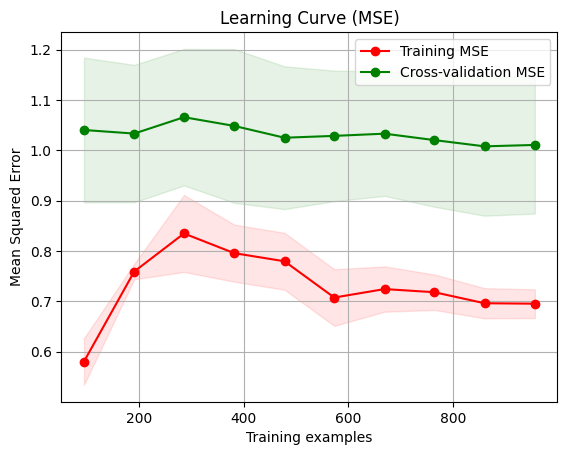

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve_mse(train_sizes, train_mse, valid_mse, title='Learning Curve (MSE)'):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.grid()

    train_mse_mean = np.mean(train_mse, axis=1)
    train_mse_std = np.std(train_mse, axis=1)
    valid_mse_mean = np.mean(valid_mse, axis=1)
    valid_mse_std = np.std(valid_mse, axis=1)

    plt.fill_between(train_sizes, train_mse_mean - train_mse_std,
                     train_mse_mean + train_mse_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, valid_mse_mean - valid_mse_std,
                     valid_mse_mean + valid_mse_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mse_mean, 'o-', color="r", label="Training MSE")
    plt.plot(train_sizes, valid_mse_mean, 'o-', color="g", label="Cross-validation MSE")

    plt.legend(loc="best")
    return plt

    # Compute the learning curve
train_sizes, train_mse, valid_mse = learning_curve(
    estimator=gbm,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error'
)

# Plot the learning curve
plot_learning_curve_mse(train_sizes, -train_mse, -valid_mse)
plt.show()

